# 第2回 (11/9)　Multi Layer Perceptron (MLP) のライブラリ無し実装
- もちろんnumpyは使います！！

## 0. MNISTデータの読み込み
- MNIST: 手書き数字の大規模データセット
    - 0〜9の10クラス
    - 訓練データ60000枚、テストデータ10000枚
    - 28\*28のグレースケール画像
- 研究室のサーバから読み込む


- X: 画像データ
    - X_trainは60000\*784, X_testは10000\*784の行列
- y: ラベル
    - np.eye(10)[〜]によってone-of-k表現にしておく
- N: サンプル数
- 一般的なDeep Learningライブラリでは変数はfloat32もしくはint32型に統一するのでここでもそうしておく

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dir = '/data/ishimochi0/dataset/mnist/'

#  訓練データ
X_train = np.loadtxt(dir + 'train-images.txt').reshape((-1, 784)).astype(np.float32) / 255.
y_train = np.loadtxt(dir + 'train-labels.txt').astype(np.int32)
y_train = np.eye(10)[y_train].astype(np.int32)
N_train = len(X_train)

# テストデータ
X_test = np.loadtxt(dir + 'test-images.txt').reshape((-1, 784)).astype(np.float32) / 255.
y_test = np.loadtxt(dir + 'test-labels.txt').astype(np.int32)
y_test = np.eye(10)[y_test].astype(np.int32)
N_test = len(X_test)

## 1. 活性化関数とその微分

### sigmoid関数
$$
\sigma(x) = \frac{1} {1+e^{-x}}
$$
<img src="figure/sigmoid.png", width=300>

In [3]:
class Sigmoid:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))# WRITE ME!
    
    def deriv(self, x):
        return self(x) * (1 -  self(x))# WRITE ME!

#### 答え合わせ

In [4]:
sigmoid = Sigmoid()

x = np.arange(10).reshape((2, 5)) - 5
print(x)

print(sigmoid(x)) # call関数(=普通のsigmoid関数)が実行される
print(sigmoid.deriv(x)) # 導関数が実行される

[[-5 -4 -3 -2 -1]
 [ 0  1  2  3  4]]
[[ 0.00669285  0.01798621  0.04742587  0.11920292  0.26894142]
 [ 0.5         0.73105858  0.88079708  0.95257413  0.98201379]]
[[ 0.00664806  0.01766271  0.04517666  0.10499359  0.19661193]
 [ 0.25        0.19661193  0.10499359  0.04517666  0.01766271]]


### relu関数
$$
relu(x) = max(0, x)
$$
<img src="figure/relu.png", width=300>

#### ヒント
- 入力xはデータ数\*次元数の行列であることに注意
- 「x>0」とすると、xの各成分の正負に応じたTrueとFalseからなる行列が得られる
- Trueは1, Falseは0として振舞う

In [5]:
x = np.arange(10).reshape((2, 5)) - 5
print(x)

print(x > 0)

print(1 * True)
print(1 * False)

[[-5 -4 -3 -2 -1]
 [ 0  1  2  3  4]]
[[False False False False False]
 [False  True  True  True  True]]
1
0


In [6]:
class ReLU:
    def __call__(self, x):
        return x * (x > 0)# WRITE ME!
    
    def deriv(self, x):
        return 1 * (x > 0)# WRITE ME!

#### 答え合わせ

In [7]:
relu = ReLU()

x = np.arange(10).reshape(2, 5) - 5
print(x)

print(relu(x))
print(relu.deriv(x))

[[-5 -4 -3 -2 -1]
 [ 0  1  2  3  4]]
[[0 0 0 0 0]
 [0 1 2 3 4]]
[[0 0 0 0 0]
 [0 1 1 1 1]]


### softmax関数
$$
softmax(x_{k}) = \frac{e^{x_{k}}} {\Sigma_{i=1}^{K}{e^{x_{i}}}}
$$
- 多クラス識別ネットワークの出力層に必ず使用する活性化関数
- xの各成分の対数を取り、各行の和が1になるよう正規化する
- 各データが各クラスに属する確率を表す

#### ヒント
各行の和を取るにはnp.sum()を使うが...
- 普通にnp.sum(a)とすると、aの全要素の和が計算されてしまう。行方向の和を取るには??
- それだけだと、割り算のサイズが合わないと怒られてしまう。行方向の和を取ったときに、行方向の次元数が1になってしまうからである。それを回避するには??
 - Shift+tabで関数の使い方を見てみよう
 
- これをそのまま実装すると、$x$の値が大きすぎる時に計算がうまくいかない時がある。（値のオーバーフロー）
$$
\begin{align}
    softmax(x_{k}) 
    &= \frac{e^{x_{k}}} {\Sigma_{i=1}^{K}{e^{x_{i}}}} \\\
    &= \frac{Ce^{x_{k}}} {C\Sigma_{i=1}^{K}{e^{x_{i}}}} \\\
    &= \frac{\exp(x_{k} - C')} {\Sigma_{i=1}^{K}{\exp(x_{i} - C')}}
\end{align}
$$

であるので、$C' = \max\{ x_{1}, \cdots ,x_{K} \}$ とすることで回避できる。

In [8]:
class Softmax:
    def __call__(self, x):
        c = np.max(x, axis=1)[:, np.newaxis]
        return np.exp(x - c) / np.sum(np.exp(x - c), axis=1, keepdims=True) # WRITE ME! 

    def deriv(self, x):
        return self(x) * (1 -  self(x))# WRITE ME!

#### 答え合わせ

In [9]:
softmax = Softmax()

x = np.arange(10).reshape(2, 5) - 5
print(x)

print(softmax(x))
print(softmax.deriv(x))
x = np.array([[1010, 1000, 990],
                        [2020, 2000, 1980]])
print(softmax(x))

[[-5 -4 -3 -2 -1]
 [ 0  1  2  3  4]]
[[ 0.01165623  0.03168492  0.08612854  0.23412166  0.63640865]
 [ 0.01165623  0.03168492  0.08612854  0.23412166  0.63640865]]
[[ 0.01152036  0.03068099  0.07871042  0.17930871  0.23139268]
 [ 0.01152036  0.03068099  0.07871042  0.17930871  0.23139268]]
[[  9.99954600e-01   4.53978686e-05   2.06106005e-09]
 [  9.99999998e-01   2.06115362e-09   4.24835425e-18]]


## 2. 線形層クラス
- 作成時の引数: 入力次元数in_dim、出力次元数out_dim、活性化関数の種類


- 内部パラメータ: 重みW(=in_dim*out_dim), バイアスb(=out_dim), 誤差delta
 - Wの初期値は一様分布に従う乱数。範囲は上手い決め方があるが今回は-0.08〜0.08とする
 - bの初期値は0ベクトル
 - どちらもfloat32型にしておこう
 
 
- call関数: 順伝播の計算
 - u: 入力xに重みWとバイアスbを適用した結果
 - z: uに活性化関数を適用した結果

In [10]:
class Linear:
    def __init__(self, in_dim, out_dim, activation):
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype(np.float32)# WRITE ME!
        self.b = np.zeros(out_dim).astype(np.float32)# WRITE ME!
        self.delta = None
        self.activation = activation()

    def __call__(self, x):
        self.u = np.dot(x, self.W) + self.b# WRITE ME!
        self.z = self.activation(self.u)# WRITE ME!
        return self.z

## 3. MLPクラス
- 作成時の引数: 層のリストlayers=[Linear(〜), Linear(〜), ...]
- 3層の場合の例:
<img src="figure/train.png", width=800>

In [11]:
class MLP():
    def __init__(self, layers):
        self.layers = layers
        
    def train(self, x, t, lr):     
        # 1. 順伝播
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)# WRITE ME!
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)# WRITE ME!
        
        # 2. 誤差逆伝播
        # 最終層の誤差
        delta = self.y - t# WRITE ME!
        self.layers[-1].delta = delta
        W = self.layers[-1].W
        
        # 中間層の誤差を計算
        # 各ループ開始時に、一つ上の層の誤差と重みがそれぞれdelta、Wに格納されている
        for layer in self.layers[-2::-1]:
            delta = np.dot(delta, W.T) * layer.activation.deriv(layer.u)# WRITE ME!
            layer.delta = delta
            W = layer.W
        
        # 3. 各層のパラメータを更新
        # 各ループ開始時に、一つ下の層の出力がzに格納されている
        z = x
        for layer in self.layers:
            dW = np.dot(z.T, layer.delta)# WRITE ME!
            db = np.dot(np.ones(len(z)), layer.delta)# WRITE ME!
            layer.W -= lr * dW# WRITE ME!
            layer.b -= lr * db# WRITE ME!
            z = layer.z
            
        return self.loss
    
    
    def test(self, x, t):
        # 順伝播 (train関数と全く同じでOK)
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)# WRITE ME!
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)# WRITE ME!
        return self.loss

- 準備はここまで。

## 4. モデルの定義

In [14]:
model = MLP([Linear(784, 1000, Sigmoid),
                        Linear(1000, 1000, Sigmoid),
                        Linear(1000, 10, Softmax)])

## 5. MNISTの学習
- 来週chainerを使って実装するときとほっとんど同じ書き方をしました！
- 注意点
 - 学習時は毎回順番がランダムになるようにする
 - accuracyの計算
 - print文はカンマを付けると改行されない
 - 学習に影響はないが、時々log0エラーが出てlossがnanになることがある

In [15]:
n_epoch = 20
batchsize = 100
lr = 0.01

losses = {'train':[], 'test': []}
accuracies = {'train':[], 'test':[]}
for epoch in range(n_epoch):
    print('epoch %d |' % epoch,)
    
    # Training
    sum_loss = 0
    pred_y = []
    perm = np.random.permutation(N_train)
    
    for i in range(0, N_train, batchsize):
        x = X_train[perm[i:i+batchsize]]
        t = y_train[perm[i:i+batchsize]]
        
        sum_loss += model.train(x, t, lr) * len(x)
        pred_y.extend(np.argmax(model.y, axis=1))
    
    loss = sum_loss / N_train
    losses['train'].append(loss)
    accuracy = np.sum(np.eye(10)[pred_y] * y_train[perm]) / N_train
    accuracies['train'].append(accuracy)
    print('Train loss %.3f, accuracy %.4f |' %(loss, accuracy),)
    
    
    # Testing
    sum_loss = 0
    pred_y = []
    
    for i in range(0, N_test, batchsize):
        x = X_test[i: i+batchsize]
        t = y_test[i: i+batchsize]
        
        sum_loss += model.test(x, t) * len(x)
        pred_y.extend(np.argmax(model.y, axis=1))

    loss = sum_loss / N_test
    losses['test'].append(loss)
    accuracy = np.sum(np.eye(10)[pred_y] * y_test) / N_test
    accuracies['test'].append(accuracy)
    print('Test loss %.3f, accuracy %.4f' %(loss, accuracy))

epoch 0 |
Train loss 1.164, accuracy 0.6148 |
Test loss 0.323, accuracy 0.9045
epoch 1 |
Train loss 0.309, accuracy 0.9071 |
Test loss 0.242, accuracy 0.9267
epoch 2 |
Train loss 0.232, accuracy 0.9290 |
Test loss 0.185, accuracy 0.9427
epoch 3 |
Train loss 0.188, accuracy 0.9435 |
Test loss 0.164, accuracy 0.9485
epoch 4 |
Train loss 0.159, accuracy 0.9523 |
Test loss 0.150, accuracy 0.9520
epoch 5 |
Train loss 0.137, accuracy 0.9585 |
Test loss 0.136, accuracy 0.9565
epoch 6 |
Train loss 0.121, accuracy 0.9636 |
Test loss 0.117, accuracy 0.9626
epoch 7 |
Train loss 0.108, accuracy 0.9678 |
Test loss 0.118, accuracy 0.9622
epoch 8 |
Train loss 0.096, accuracy 0.9712 |
Test loss 0.102, accuracy 0.9675
epoch 9 |
Train loss 0.087, accuracy 0.9740 |
Test loss 0.096, accuracy 0.9687
epoch 10 |
Train loss 0.079, accuracy 0.9750 |
Test loss 0.100, accuracy 0.9686
epoch 11 |
Train loss 0.071, accuracy 0.9783 |
Test loss 0.093, accuracy 0.9701
epoch 12 |
Train loss 0.066, accuracy 0.9797 |
Tes

- デフォルトのネットワークでは、97%台後半程度の識別精度が出たと思います。
- 中間層の活性化関数をReLUに変えてみたり、層数を増やしてみたりすると...?

### loss, accuracyの可視化
- 学習がうまくいっているか確認

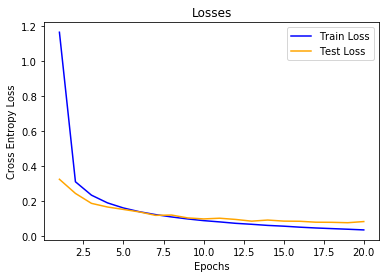

In [16]:
plt.figure()
plt.plot(np.arange(1, n_epoch + 1), losses['train'], 'blue', label='Train Loss')
plt.plot(np.arange(1, n_epoch + 1), losses['test'], 'orange', label='Test Loss')

plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.title("Losses")
plt.show()

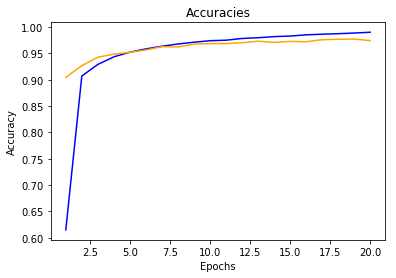

In [17]:
plt.figure()
plt.plot(np.arange(1, n_epoch + 1), accuracies['train'], \
         'blue', label='Train Accuracy')
plt.plot(np.arange(1, n_epoch + 1), accuracies['test'], \
         'orange', label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracies")
plt.show()